In [49]:
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import ee
import json
ee.Initialize()

In [41]:
 # load your shapefile using geopandas
shapefile_path = r"E:\GIS\projects\rainfall_app\nobleton\nobleton.shp"
gdf = gpd.read_file(shapefile_path)

In [42]:
# check the contents of the shapefile
print(gdf)

   SiteID  Season                         Agency    FOCode  \
0   861.0  2008.0  Regional Municipality of York  2008.360   
1  3801.0  2012.0  Regional Municipality of York  2012.233   
2     0.0     0.0                           None     0.000   

                     SiteName  \
0  Nobleton Tract 100b & 100c   
1       Nobleton Tract - 100d   
2                        None   

                                          SpeciesCon  AllTimePla      area  \
0  Cherry, Black: 200.0, Maple, Silver: 1000.0, B...     22300.0  0.000006   
1  Pine, Eastern White: 1000.0, Cedar, Eastern Wh...      4600.0  0.000002   
2                                               None         0.0  0.000000   

   Shape_Leng  Shape_Area                                           geometry  
0    0.011647    0.000006  POLYGON Z ((-79.63611 43.92041 0, -79.63502 43...  
1    0.006429    0.000002  POLYGON Z ((-79.63434 43.92082 0, -79.63511 43...  
2    0.000000    0.000000                                           

In [43]:
# Convert the first geometry to GeoJSON
geojson = gdf.iloc[0].geometry.__geo_interface__

In [44]:
print(geojson)

{'type': 'Polygon', 'coordinates': (((-79.63611455999995, 43.92041262600003, 0.0), (-79.63501735199998, 43.920652231000076, 0.0), (-79.63479174299994, 43.92039455500003, 0.0), (-79.63455534299999, 43.92035245500006, 0.0), (-79.63439020499999, 43.92039554400003, 0.0), (-79.63433778399997, 43.920549332000064, 0.0), (-79.63435319899997, 43.92068801400006, 0.0), (-79.63438917199994, 43.920803170000056, 0.0), (-79.63342762299999, 43.921012544000064, 0.0), (-79.63321418099997, 43.92082952900006, 0.0), (-79.63297144499995, 43.92069567100003, 0.0), (-79.63272495099994, 43.92038895600007, 0.0), (-79.63250535099996, 43.92015046700004, 0.0), (-79.63226827699998, 43.91996324000007, 0.0), (-79.63202537999996, 43.91979310000005, 0.0), (-79.63178505999997, 43.919541855000034, 0.0), (-79.63164271799997, 43.91940775000006, 0.0), (-79.63192330699997, 43.91943054400008, 0.0), (-79.63212989799996, 43.919412968000074, 0.0), (-79.63235121999998, 43.919388953000066, 0.0), (-79.63266676099994, 43.919309220000

In [45]:
# Function to strip the Z-coordinate from the GeoJSON
def remove_z_coordinates(geojson):
    def process_coords(coords):
        # If it's a Polygon or MultiPolygon, recursively strip Z-values
        return [[(x, y) for x, y, z in ring] for ring in coords]

    # Handle the specific case of a Polygon
    if geojson['type'] == 'Polygon':
        geojson['coordinates'] = process_coords(geojson['coordinates'])
    
    # You can extend this to other geometry types (e.g., MultiPolygon, LineString) as needed
    return geojson

# Remove Z-coordinates
geojson_2d = remove_z_coordinates(geojson)


In [46]:
# create the earth engine geometry for Nobleton
aoi = ee.Geometry(geojson_2d)

In [47]:
# verify the result
print(aoi.getInfo())

{'type': 'Polygon', 'coordinates': [[[-79.63611455999995, 43.92041262600003], [-79.63611061399996, 43.92020348900007], [-79.63577072299995, 43.918883297000036], [-79.63570494099997, 43.91870846000006], [-79.63556310599995, 43.91868320200007], [-79.63542760899998, 43.91874969500003], [-79.63514428099995, 43.91877173700004], [-79.63491713899998, 43.91881284600004], [-79.63455141499998, 43.91889271000008], [-79.63426825699997, 43.91895102900003], [-79.63422131999994, 43.919015168000044], [-79.63411819699996, 43.91906023900003], [-79.63398526799995, 43.91904562600007], [-79.63377268499994, 43.919044014000065], [-79.63347770499996, 43.91910022500008], [-79.63310615199998, 43.919197171000064], [-79.63266676099994, 43.91930922000006], [-79.63235121999998, 43.919388953000066], [-79.63212989799996, 43.919412968000074], [-79.63192330699997, 43.91943054400008], [-79.63164271799997, 43.91940775000006], [-79.63178505999997, 43.919541855000034], [-79.63202537999996, 43.91979310000005], [-79.63226827

In [50]:
# Access the CHIRPS dataset
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')

# Define the range of years
start_year = 2004
end_year = 2023

# Prepare an empty list to store the yearly data
all_years_data = []

# Loop through each year
for year in range(start_year, end_year + 1):
    # Loop through each month (1 to 12) within the year
    for month in range(1, 13):
        # Define the date range for the current month
        month_start = f'{year}-{month:02d}-01'
        month_end = f'{year}-{month:02d}-28'  # Approximation for months
        
        # Filter the dataset for the specific month and year
        monthly_image = chirps.filterBounds(aoi).filterDate(month_start, month_end).mean()
        
        # Reduce the image to get the mean precipitation over the AOI
        mean_rainfall = monthly_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=5000  # Adjust scale as needed
        )
        
        # Extract the mean precipitation value
        rainfall_value = mean_rainfall.get('precipitation').getInfo()
        
        # Append year, month, and precipitation to the list
        all_years_data.append({
            'Year': year,
            'Month': month,
            'Mean Rainfall (mm)': rainfall_value
        })

# Convert the yearly data to a pandas DataFrame
rainfall_df = pd.DataFrame(all_years_data)

# Print the DataFrame to check
print(rainfall_df)

# Save to CSV
rainfall_df.to_csv('Rainfall_2004_2023_Nobleton.csv', index=False)

     Year  Month  Mean Rainfall (mm)
0    2004      1            9.740794
1    2004      2            5.952337
2    2004      3           11.464190
3    2004      4           13.024937
4    2004      5           17.958704
..    ...    ...                 ...
235  2023      8           11.571423
236  2023      9            4.869616
237  2023     10            8.820762
238  2023     11           12.309420
239  2023     12           15.415360

[240 rows x 3 columns]


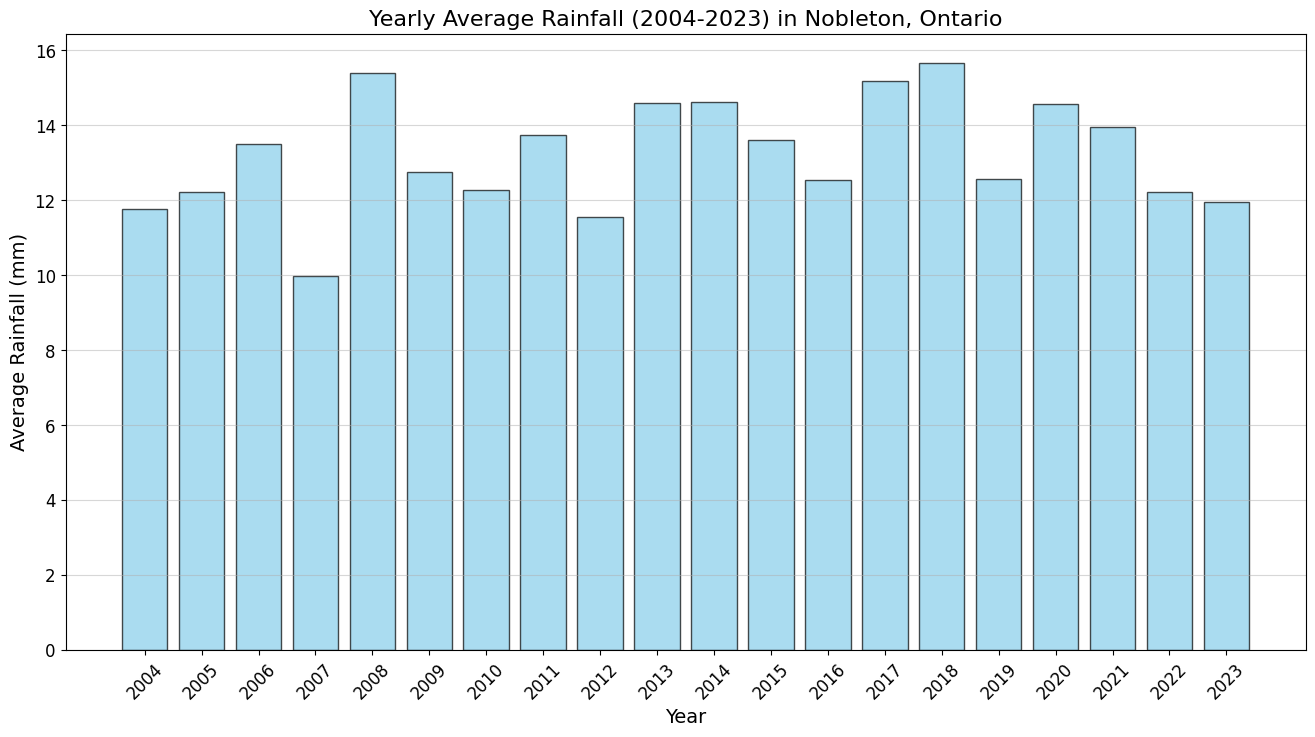

In [54]:
# load the csv data
rainfall_df = pd.read_csv(r'C:\Users\Tedi\Rainfall_2004_2023_Nobleton.csv')

# calculate the average rainfall for each year
yearly_avg_rainfall = rainfall_df.groupby('Year')['Mean Rainfall (mm)'].mean().reset_index()

# plot the bar graph
plt.figure(figsize=(16, 8))
plt.bar(
    yearly_avg_rainfall['Year'],
    yearly_avg_rainfall['Mean Rainfall (mm)'],
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)
#customize the plot
plt.title('Yearly Average Rainfall (2004-2023) in Nobleton, Ontario', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Rainfall (mm)', fontsize=14)
plt.xticks(yearly_avg_rainfall['Year'], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5)
# save the plot to a file
plt.savefig('Nobleton_yearly_avg_rainfall_bar_chart.png', dpi=300, bbox_inches='tight')
# show the plot
plt.show()

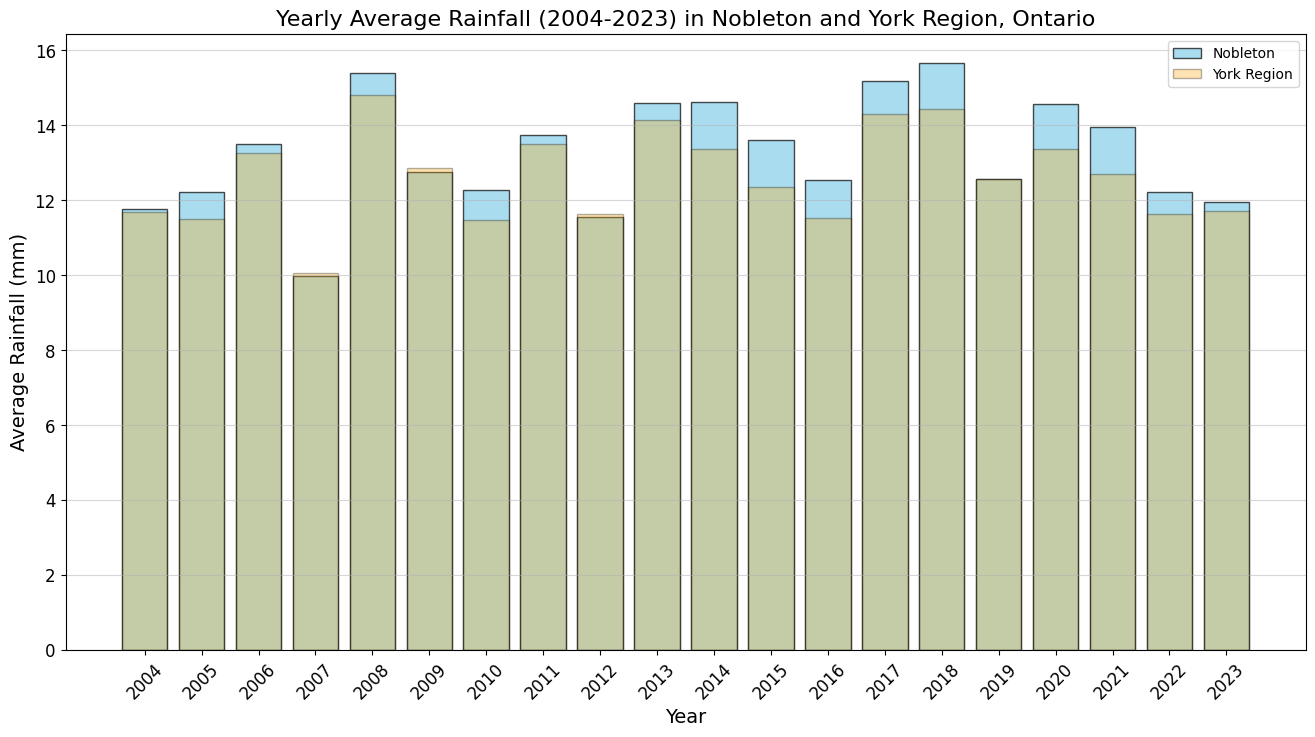

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the first CSV data (Nobleton)
rainfall_df_nobleton = pd.read_csv(r'C:\Users\Tedi\Rainfall_2004_2023_Nobleton.csv')
yearly_avg_rainfall_nobleton = rainfall_df_nobleton.groupby('Year')['Mean Rainfall (mm)'].mean().reset_index()

# Load the second CSV data (York Region)
rainfall_df_york_region = pd.read_csv(r'C:\Users\Tedi\Rainfall_2004_2023_YorkRegion.csv')
yearly_avg_rainfall_york_region = rainfall_df_york_region.groupby('Year')['Mean Rainfall (mm)'].mean().reset_index()

# Create the plot
plt.figure(figsize=(16, 8))

# Plot the Nobleton data with solid bars
plt.bar(
    yearly_avg_rainfall_nobleton['Year'],
    yearly_avg_rainfall_nobleton['Mean Rainfall (mm)'],
    color='skyblue',
    edgecolor='black',
    alpha=0.7,
    label='Nobleton'
)

# Plot the York Region data with transparent bars
plt.bar(
    yearly_avg_rainfall_york_region['Year'],
    yearly_avg_rainfall_york_region['Mean Rainfall (mm)'],
    color='orange',
    edgecolor='black',
    alpha=0.3,  # Make this dataset transparent
    label='York Region'
)

# Customize the plot
plt.title('Yearly Average Rainfall (2004-2023) in Nobleton and York Region, Ontario', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Rainfall (mm)', fontsize=14)
plt.xticks(yearly_avg_rainfall_nobleton['Year'], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.legend()  # Add a legend to differentiate the two datasets

# Save the plot to a file
plt.savefig('yearly_avg_rainfall_combined_chart.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
